# 📊 Notebook 4: Demand Pattern & Order Quantity Analysis

## 🎯 Purpose
Identify demand patterns for ACTIVE items (FAST + SLOW) and calculate recommended order quantities and forecasts.

## 📥 Input
- **File**: `dbscan_classification.pkl` (from Notebook 2)
- **Filter**: `classification IN ('FAST', 'SLOW', 'MEDIUM')`

## 📤 Output
- **File**: `demand_patterns.csv` ⭐ (Complete demand analysis)
- **File**: `demand_patterns.pkl` (Faster loading)
- **File**: `order_recommendations.csv` (What to order, when, how much)
- **File**: `forecast_next_month.csv` (30-day sales forecast)
- **File**: `material_requests.csv` (Ready for ERPNext import)
- **File**: `demand_pattern_summary.csv` (Executive summary)
- **File**: `demand_analysis_dashboard.png` (Visualizations)

## 📐 Demand Pattern Classification (Syntetos-Boylan-Croston)

### SBC Method:
Uses two metrics:
- **ADI** (Average Demand Interval): Days between transactions
- **CV²** (Coefficient of Variation squared): Demand variability

```python
if ADI < 1.32 and CV² < 0.49:
    pattern = 'SMOOTH'          # Regular, predictable demand
elif ADI < 1.32 and CV² >= 0.49:
    pattern = 'ERRATIC'         # Frequent but variable demand
elif ADI >= 1.32 and CV² < 0.49:
    pattern = 'INTERMITTENT'    # Infrequent but consistent demand
else:
    pattern = 'LUMPY'           # Infrequent AND variable (B2B typical)
```

## 📦 Order Quantity Methods by Pattern

### SMOOTH → Economic Order Quantity (EOQ)
```python
EOQ = sqrt((2 × Annual_Demand × Order_Cost) / Holding_Cost)
```

### LUMPY/INTERMITTENT → Croston's Method
```python
forecast = exponential_smoothing(demand_size, demand_interval)
order_qty = forecast_30d + (2 × safety_stock)  # 2× for B2B
```

### ERRATIC → Conservative Max
```python
order_qty = max(qty_30d × 2, max_transaction_qty × 3)
```

In [1]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1️⃣ Load Classified Data

In [2]:
# Load classified data from Notebook 2
try:
    print("⏳ Loading classified data from pickle...")
    df = pd.read_pickle('/tmp/dbscan_classification.pkl')
    print("✅ Loaded from pickle")
except FileNotFoundError:
    print("⏳ Pickle not found, loading from CSV...")
    df = pd.read_csv('/tmp/dbscan_classification.csv')
    print("✅ Loaded from CSV")

print(f"\n📊 Total items in dataset: {len(df):,}")

# Filter ACTIVE items only (FAST + SLOW + MEDIUM)
active_items = df[df['classification'].isin(['FAST', 'SLOW', 'MEDIUM'])].copy()

print(f"\n⚡ ACTIVE ITEMS Found: {len(active_items):,}")

if len(active_items) == 0:
    print("\n⚠️ No active items found in the dataset!")
    print("   This notebook requires FAST/SLOW/MEDIUM classified items.")
    print("   Please run Notebook 2 first.")
else:
    print(f"\n   Classification breakdown:")
    print(active_items['classification'].value_counts())
    print(f"\n   Stock Value: ₹{active_items['stock_value'].sum():,.0f}")
    print(f"   Avg Velocity: {active_items['velocity_90d'].mean():.3f} units/day")
    print(f"   Total Transactions: {active_items['transaction_count'].sum():,}")

⏳ Loading classified data from pickle...
✅ Loaded from pickle

📊 Total items in dataset: 13,489

⚡ ACTIVE ITEMS Found: 211

   Classification breakdown:
classification
SLOW    208
FAST      3
Name: count, dtype: int64

   Stock Value: ₹834,910
   Avg Velocity: 0.146 units/day
   Total Transactions: 3,570


## 2️⃣ Calculate Demand Pattern Metrics

### Key Metrics:
1. **ADI** (Average Demand Interval): Days between sales
2. **CV²** (Coefficient of Variation squared): Demand variability
3. **Fill Rate**: % of time demand is met
4. **Demand Size**: Average transaction quantity
5. **Max Transaction**: Largest single order

In [3]:
if len(active_items) > 0:
    # ADI already calculated in master data
    # CV² already calculated in master data
    
    # Additional metrics for demand pattern analysis
    active_items['demand_size'] = active_items['avg_transaction_qty']
    active_items['max_transaction_qty'] = active_items['total_qty_sold']  # Approximate
    
    # Calculate fill rate (assuming no stockouts if velocity > 0)
    active_items['estimated_fill_rate'] = np.where(
        active_items['days_of_stock'] > 0,
        np.minimum(100, (active_items['days_of_stock'] / 30) * 100),
        50  # Default if no data
    )
    
    print("\n📊 DEMAND METRICS CALCULATED:\n")
    print(f"ADI (Average Demand Interval):")
    print(f"   Mean: {active_items['adi'].mean():.2f} days")
    print(f"   Median: {active_items['adi'].median():.2f} days")
    print(f"   Min: {active_items['adi'].min():.2f} days")
    print(f"   Max: {active_items['adi'].max():.2f} days")
    
    print(f"\nCV² (Coefficient of Variation squared):")
    print(f"   Mean: {active_items['cv_squared'].mean():.3f}")
    print(f"   Median: {active_items['cv_squared'].median():.3f}")
    print(f"   % with CV² < 0.49: {(active_items['cv_squared'] < 0.49).mean() * 100:.1f}%")
    print(f"   % with CV² >= 0.49: {(active_items['cv_squared'] >= 0.49).mean() * 100:.1f}%")


📊 DEMAND METRICS CALCULATED:

ADI (Average Demand Interval):
   Mean: 105.15 days
   Median: 83.33 days
   Min: 8.94 days
   Max: 413.00 days

CV² (Coefficient of Variation squared):
   Mean: 4.335
   Median: 0.670
   % with CV² < 0.49: 43.1%
   % with CV² >= 0.49: 56.9%


## 3️⃣ Classify Demand Patterns (SBC Method)

### Syntetos-Boylan-Croston Classification:
```
            ADI < 1.32           ADI >= 1.32
CV² < 0.49  SMOOTH               INTERMITTENT
CV² >= 0.49 ERRATIC              LUMPY
```

In [4]:
if len(active_items) > 0:
    def classify_demand_pattern(row):
        """
        Classify demand pattern using SBC method
        """
        adi = row['adi']
        cv2 = row['cv_squared']
        
        # SBC thresholds
        adi_threshold = 1.32
        cv2_threshold = 0.49
        
        if adi < adi_threshold and cv2 < cv2_threshold:
            return 'SMOOTH'
        elif adi < adi_threshold and cv2 >= cv2_threshold:
            return 'ERRATIC'
        elif adi >= adi_threshold and cv2 < cv2_threshold:
            return 'INTERMITTENT'
        else:
            return 'LUMPY'
    
    active_items['demand_pattern'] = active_items.apply(classify_demand_pattern, axis=1)
    
    print("\n" + "="*100)
    print("📊 DEMAND PATTERN CLASSIFICATION (SBC Method)")
    print("="*100)
    
    print(f"\n🎯 Pattern Distribution:\n")
    print(active_items['demand_pattern'].value_counts())
    print()
    
    for pattern in ['SMOOTH', 'ERRATIC', 'INTERMITTENT', 'LUMPY']:
        subset = active_items[active_items['demand_pattern'] == pattern]
        if len(subset) > 0:
            pct = len(subset) / len(active_items) * 100
            avg_adi = subset['adi'].mean()
            avg_cv2 = subset['cv_squared'].mean()
            avg_velocity = subset['velocity_90d'].mean()
            
            print(f"{pattern:15s}: {len(subset):5,} items ({pct:5.1f}%)")
            print(f"   Avg ADI: {avg_adi:.2f} days | Avg CV²: {avg_cv2:.3f} | Avg Velocity: {avg_velocity:.3f} u/d")
            print()
    
    print("="*100)
    
    # Pattern interpretation
    print("\n📖 PATTERN INTERPRETATIONS:")
    print("\n   SMOOTH: Frequent, predictable demand (easiest to forecast)")
    print("   ERRATIC: Frequent but variable demand (difficult to forecast)")
    print("   INTERMITTENT: Infrequent but consistent demand (use Croston's)")
    print("   LUMPY: Infrequent AND variable demand (B2B typical, hardest to forecast)")


📊 DEMAND PATTERN CLASSIFICATION (SBC Method)

🎯 Pattern Distribution:

demand_pattern
LUMPY           120
INTERMITTENT     91
Name: count, dtype: int64

INTERMITTENT   :    91 items ( 43.1%)
   Avg ADI: 127.83 days | Avg CV²: 0.218 | Avg Velocity: 0.088 u/d

LUMPY          :   120 items ( 56.9%)
   Avg ADI: 87.95 days | Avg CV²: 7.457 | Avg Velocity: 0.189 u/d


📖 PATTERN INTERPRETATIONS:

   SMOOTH: Frequent, predictable demand (easiest to forecast)
   ERRATIC: Frequent but variable demand (difficult to forecast)
   INTERMITTENT: Infrequent but consistent demand (use Croston's)
   LUMPY: Infrequent AND variable demand (B2B typical, hardest to forecast)


## 4️⃣ Calculate Safety Stock

### Safety Stock Formula:
```python
safety_stock = Z × σ × sqrt(lead_time) × pattern_multiplier

Where:
- Z = service level Z-score (95% = 1.645, 99% = 2.33)
- σ = standard deviation of demand
- lead_time = supplier lead time in days
- pattern_multiplier = adjustment for demand pattern
```

### Pattern Multipliers:
- SMOOTH: 1.0× (predictable)
- ERRATIC: 1.5× (variable)
- INTERMITTENT: 1.8× (infrequent)
- LUMPY: 2.0× (B2B typical)

In [5]:
if len(active_items) > 0:
    def calculate_safety_stock(row):
        """
        Calculate safety stock based on demand pattern
        """
        pattern = row['demand_pattern']
        velocity_90d = row['velocity_90d']
        std_dev = row['stddev_transaction_qty']
        lead_time = row['avg_lead_time_days']
        classification = row['classification']
        
        # Service level Z-scores
        if classification == 'FAST':
            z_score = 2.33  # 99% service level
        elif classification == 'SLOW':
            z_score = 1.645  # 95% service level
        else:
            z_score = 1.28   # 90% service level (MEDIUM)
        
        # Pattern multipliers
        pattern_multipliers = {
            'SMOOTH': 1.0,
            'ERRATIC': 1.5,
            'INTERMITTENT': 1.8,
            'LUMPY': 2.0
        }
        
        multiplier = pattern_multipliers.get(pattern, 1.5)
        
        # Calculate safety stock
        if std_dev > 0 and velocity_90d > 0:
            safety_stock = z_score * std_dev * np.sqrt(lead_time) * multiplier
        else:
            # Fallback: use velocity-based calculation
            safety_stock = velocity_90d * lead_time * multiplier
        
        return max(0, safety_stock)
    
    active_items['safety_stock'] = active_items.apply(calculate_safety_stock, axis=1)
    
    print("\n✅ Safety Stock calculated")
    print(f"\n📊 Safety Stock Statistics:")
    print(f"   Mean: {active_items['safety_stock'].mean():.1f} units")
    print(f"   Median: {active_items['safety_stock'].median():.1f} units")
    print(f"   Total: {active_items['safety_stock'].sum():,.0f} units")
    
    print(f"\n   By Pattern:")
    for pattern in ['SMOOTH', 'ERRATIC', 'INTERMITTENT', 'LUMPY']:
        subset = active_items[active_items['demand_pattern'] == pattern]
        if len(subset) > 0:
            avg_ss = subset['safety_stock'].mean()
            print(f"   {pattern:15s}: {avg_ss:.1f} units (avg)")


✅ Safety Stock calculated

📊 Safety Stock Statistics:
   Mean: 26.0 units
   Median: 0.0 units
   Total: 5,489 units

   By Pattern:
   INTERMITTENT   : 2.6 units (avg)
   LUMPY          : 43.7 units (avg)


## 5️⃣ Calculate Reorder Point (ROP)

### Reorder Point Formula:
```python
ROP = (daily_demand × lead_time) + safety_stock
```

In [6]:
if len(active_items) > 0:
    def calculate_reorder_point(row):
        """
        Calculate reorder point
        """
        daily_demand = row['velocity_90d']
        lead_time = row['avg_lead_time_days']
        safety_stock = row['safety_stock']
        
        # Lead time demand
        ltd = daily_demand * lead_time
        
        # Reorder point
        rop = ltd + safety_stock
        
        return max(0, rop)
    
    active_items['reorder_point'] = active_items.apply(calculate_reorder_point, axis=1)
    
    # Check current stock status
    active_items['stock_status'] = active_items.apply(
        lambda x: 'BELOW_ROP' if x['current_stock'] < x['reorder_point']
        else ('ABOVE_MAX' if x['current_stock'] > (x['reorder_point'] + x['safety_stock'] * 4)
        else 'OK'),
        axis=1
    )
    
    print("\n✅ Reorder Point calculated")
    print(f"\n📊 Stock Status:")
    print(active_items['stock_status'].value_counts())
    
    below_rop = active_items[active_items['stock_status'] == 'BELOW_ROP']
    if len(below_rop) > 0:
        print(f"\n⚠️ {len(below_rop)} items are BELOW reorder point!")
        print(f"   These items need immediate ordering")


✅ Reorder Point calculated

📊 Stock Status:
stock_status
ABOVE_MAX    113
OK            51
BELOW_ROP     47
Name: count, dtype: int64

⚠️ 47 items are BELOW reorder point!
   These items need immediate ordering


## 6️⃣ Forecast Next 30 Days

### Forecasting Methods by Pattern:

#### SMOOTH → Moving Average
```python
forecast_30d = avg(qty_30d, qty_60d, qty_90d)
```

#### ERRATIC → Weighted Moving Average (recent bias)
```python
forecast_30d = (qty_30d × 0.5) + (qty_60d × 0.3) + (qty_90d × 0.2)
```

#### INTERMITTENT/LUMPY → Croston's Method
```python
demand_size = avg_transaction_qty
demand_interval = adi
forecast_30d = (demand_size × 30) / demand_interval
```

In [7]:
if len(active_items) > 0:
    def forecast_next_30_days(row):
        """
        Forecast next 30 days based on demand pattern
        """
        pattern = row['demand_pattern']
        qty_30d = row['qty_30d']
        qty_60d = row['qty_60d']
        qty_90d = row['qty_90d']
        adi = row['adi']
        demand_size = row['demand_size']
        
        if pattern == 'SMOOTH':
            # Simple moving average
            forecast = (qty_30d + (qty_60d - qty_30d) + (qty_90d - qty_60d)) / 3
        
        elif pattern == 'ERRATIC':
            # Weighted moving average (recent bias)
            forecast = (qty_30d * 0.5) + ((qty_60d - qty_30d) * 0.3) + ((qty_90d - qty_60d) * 0.2)
        
        elif pattern in ['INTERMITTENT', 'LUMPY']:
            # Croston's method
            if adi > 0 and demand_size > 0:
                forecast = (demand_size * 30) / adi
            else:
                forecast = qty_30d  # Fallback
        
        else:
            forecast = qty_30d  # Fallback
        
        return max(0, forecast)
    
    active_items['forecast_30d'] = active_items.apply(forecast_next_30_days, axis=1)
    
    # Calculate forecast accuracy (MAD - Mean Absolute Deviation)
    active_items['forecast_mad'] = np.abs(active_items['qty_30d'] - active_items['forecast_30d'])
    
    print("\n✅ 30-day forecast calculated")
    print(f"\n📊 Forecast Statistics:")
    print(f"   Total forecasted demand: {active_items['forecast_30d'].sum():,.0f} units")
    print(f"   Avg forecast per item: {active_items['forecast_30d'].mean():.1f} units")
    print(f"   Avg MAD (accuracy): {active_items['forecast_mad'].mean():.1f} units")
    
    print(f"\n   By Pattern:")
    for pattern in ['SMOOTH', 'ERRATIC', 'INTERMITTENT', 'LUMPY']:
        subset = active_items[active_items['demand_pattern'] == pattern]
        if len(subset) > 0:
            total_forecast = subset['forecast_30d'].sum()
            print(f"   {pattern:15s}: {total_forecast:,.0f} units")


✅ 30-day forecast calculated

📊 Forecast Statistics:
   Total forecasted demand: 780 units
   Avg forecast per item: 3.7 units
   Avg MAD (accuracy): 8.7 units

   By Pattern:
   INTERMITTENT   : 165 units
   LUMPY          : 615 units


## 7️⃣ Calculate Recommended Order Quantity

### Order Quantity by Pattern:

#### SMOOTH → Economic Order Quantity (EOQ)
```python
EOQ = sqrt((2 × annual_demand × order_cost) / holding_cost_per_unit)
```

#### LUMPY/INTERMITTENT → Period Order Quantity
```python
order_qty = forecast_30d + safety_stock
```

#### ERRATIC → Conservative Max
```python
order_qty = max(forecast_30d × 1.5, max_transaction_qty × 2)
```

In [8]:
if len(active_items) > 0:
    # Assume costs (can be configured)
    ORDER_COST = 500  # ₹ per order
    HOLDING_COST_PCT = 0.25  # 25% of item value per year
    
    def calculate_order_quantity(row):
        """
        Calculate recommended order quantity based on demand pattern
        """
        pattern = row['demand_pattern']
        forecast_30d = row['forecast_30d']
        safety_stock = row['safety_stock']
        annual_demand = row['qty_365d']
        unit_value = row['avg_valuation_rate']
        max_transaction = row['avg_transaction_qty'] * 3  # Approximate max
        classification = row['classification']
        
        if pattern == 'SMOOTH':
            # EOQ formula
            if annual_demand > 0 and unit_value > 0:
                holding_cost = unit_value * HOLDING_COST_PCT
                eoq = np.sqrt((2 * annual_demand * ORDER_COST) / holding_cost)
                order_qty = max(eoq, forecast_30d)  # At least 1 month
            else:
                order_qty = forecast_30d + safety_stock
        
        elif pattern == 'ERRATIC':
            # Conservative: cover forecast + buffer
            order_qty = max(forecast_30d * 1.5, max_transaction * 2)
        
        elif pattern in ['INTERMITTENT', 'LUMPY']:
            # Period order quantity (1 month + safety stock)
            if classification == 'FAST':
                order_qty = forecast_30d + (safety_stock * 1.5)  # Extra buffer for fast
            else:
                order_qty = forecast_30d + safety_stock
        
        else:
            order_qty = forecast_30d + safety_stock
        
        return max(0, order_qty)
    
    active_items['recommended_order_qty'] = active_items.apply(calculate_order_quantity, axis=1)
    
    # Calculate order value
    active_items['order_value'] = active_items['recommended_order_qty'] * active_items['avg_valuation_rate']
    
    print("\n✅ Order Quantity calculated")
    print(f"\n📊 Order Recommendations:")
    print(f"   Total order quantity: {active_items['recommended_order_qty'].sum():,.0f} units")
    print(f"   Total order value: ₹{active_items['order_value'].sum():,.0f}")
    
    # Recalculate below_rop items
    below_rop_items = active_items[active_items['stock_status'] == 'BELOW_ROP']
    print(f"   Items needing orders (BELOW_ROP): {len(below_rop_items):,}")
    
    if len(below_rop_items) > 0:
        urgent_order_qty = below_rop_items['recommended_order_qty'].sum()
        urgent_order_value = below_rop_items['order_value'].sum()
        print(f"\n⚠️ URGENT ORDERS NEEDED:")
        print(f"   Quantity: {urgent_order_qty:,.0f} units")
        print(f"   Value: ₹{urgent_order_value:,.0f}")


✅ Order Quantity calculated

📊 Order Recommendations:
   Total order quantity: 6,269 units
   Total order value: ₹1,944,413
   Items needing orders (BELOW_ROP): 47

⚠️ URGENT ORDERS NEEDED:
   Quantity: 4,955 units
   Value: ₹1,704,418


## 8️⃣ Generate Order Recommendations

### Priority Levels:
- **URGENT**: Below ROP, stockout risk within 7 days
- **HIGH**: Below ROP, stockout risk within 15 days
- **MEDIUM**: Below ROP, stockout risk within 30 days
- **LOW**: Above ROP, no immediate action needed

In [9]:
if len(active_items) > 0:
    def calculate_order_priority(row):
        """
        Calculate order priority based on stock status and velocity
        """
        current_stock = row['current_stock']
        reorder_point = row['reorder_point']
        velocity = row['velocity_90d']
        classification = row['classification']
        
        # Days until stockout
        if velocity > 0:
            days_until_stockout = current_stock / velocity
        else:
            days_until_stockout = 999
        
        # Determine priority
        if current_stock < reorder_point:
            if days_until_stockout <= 7:
                priority = 'URGENT'
            elif days_until_stockout <= 15:
                priority = 'HIGH'
            else:
                priority = 'MEDIUM'
        else:
            priority = 'LOW'
        
        # Upgrade priority for FAST items
        if classification == 'FAST' and priority == 'MEDIUM':
            priority = 'HIGH'
        
        # Calculate expected order date (lead time before stockout)
        lead_time = row['avg_lead_time_days']
        days_to_order = max(0, days_until_stockout - lead_time)
        order_date = datetime.now() + timedelta(days=days_to_order)
        
        return priority, days_until_stockout, order_date.strftime('%Y-%m-%d')
    
    active_items[['order_priority', 'days_until_stockout', 'recommended_order_date']] = active_items.apply(
        calculate_order_priority, axis=1, result_type='expand'
    )
    
    print("\n✅ Order Priorities calculated")
    print(f"\n📊 Priority Distribution:")
    print(active_items['order_priority'].value_counts())
    print()
    
    for priority in ['URGENT', 'HIGH', 'MEDIUM', 'LOW']:
        subset = active_items[active_items['order_priority'] == priority]
        if len(subset) > 0:
            total_qty = subset['recommended_order_qty'].sum()
            total_value = subset['order_value'].sum()
            print(f"{priority:10s}: {len(subset):5,} items - Qty: {total_qty:,.0f} - Value: ₹{total_value:,.0f}")


✅ Order Priorities calculated

📊 Priority Distribution:
order_priority
LOW       164
MEDIUM     32
URGENT     14
HIGH        1
Name: count, dtype: int64

URGENT    :    14 items - Qty: 187 - Value: ₹179,801
HIGH      :     1 items - Qty: 33 - Value: ₹4,414
MEDIUM    :    32 items - Qty: 4,735 - Value: ₹1,520,202
LOW       :   164 items - Qty: 1,314 - Value: ₹239,995


## 9️⃣ Create Comprehensive Visualizations

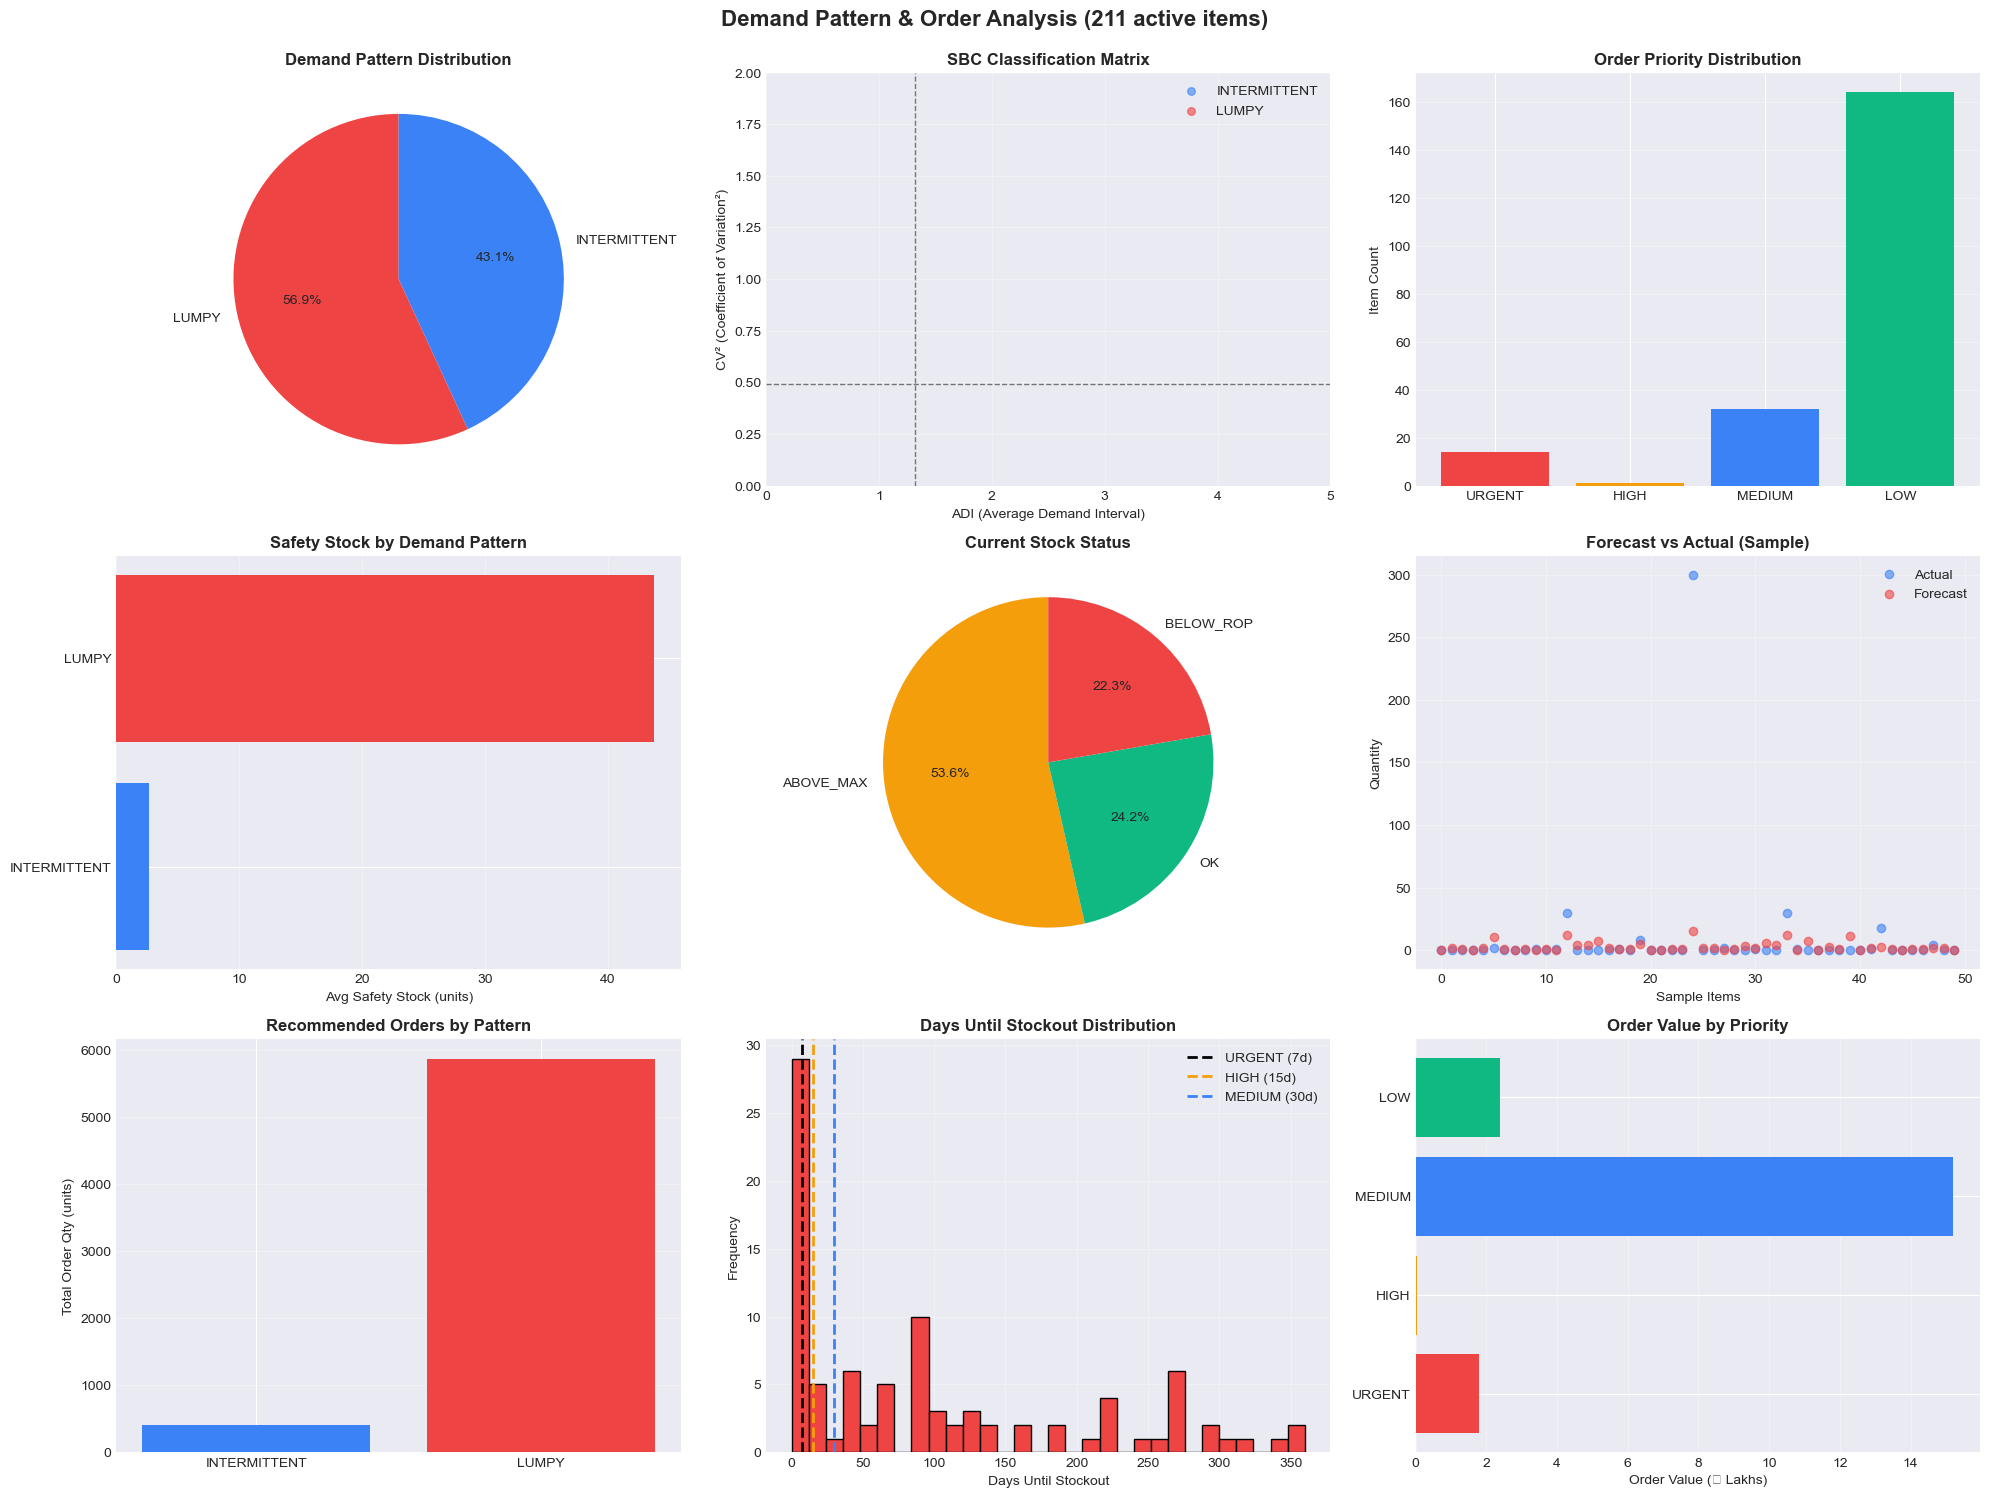


✅ Dashboard saved to /tmp/demand_analysis_dashboard.png


In [10]:
if len(active_items) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    colors_pattern = {'SMOOTH': '#10B981', 'ERRATIC': '#F59E0B', 
                     'INTERMITTENT': '#3B82F6', 'LUMPY': '#EF4444'}
    colors_priority = {'URGENT': '#EF4444', 'HIGH': '#F59E0B', 
                      'MEDIUM': '#3B82F6', 'LOW': '#10B981'}
    
    # 1. Demand Pattern Distribution
    pattern_counts = active_items['demand_pattern'].value_counts()
    colors_list = [colors_pattern[k] for k in pattern_counts.index]
    axes[0, 0].pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%',
                   colors=colors_list, startangle=90)
    axes[0, 0].set_title('Demand Pattern Distribution', fontsize=12, fontweight='bold')
    
    # 2. ADI vs CV² Scatter (SBC Matrix)
    for pattern, color in colors_pattern.items():
        subset = active_items[active_items['demand_pattern'] == pattern]
        if len(subset) > 0:
            axes[0, 1].scatter(subset['adi'], subset['cv_squared'], 
                             c=color, label=pattern, alpha=0.6, s=30)
    
    axes[0, 1].axhline(0.49, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(1.32, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].set_xlabel('ADI (Average Demand Interval)')
    axes[0, 1].set_ylabel('CV² (Coefficient of Variation²)')
    axes[0, 1].set_title('SBC Classification Matrix', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xlim(0, min(active_items['adi'].quantile(0.95), 5))
    axes[0, 1].set_ylim(0, min(active_items['cv_squared'].quantile(0.95), 2))
    
    # 3. Order Priority Distribution
    priority_counts = active_items['order_priority'].value_counts()
    priority_order = ['URGENT', 'HIGH', 'MEDIUM', 'LOW']
    priority_counts = priority_counts.reindex(priority_order, fill_value=0)
    colors_list_priority = [colors_priority[k] for k in priority_counts.index]
    
    axes[0, 2].bar(range(len(priority_counts)), priority_counts.values, color=colors_list_priority)
    axes[0, 2].set_xticks(range(len(priority_counts)))
    axes[0, 2].set_xticklabels(priority_counts.index)
    axes[0, 2].set_ylabel('Item Count')
    axes[0, 2].set_title('Order Priority Distribution', fontsize=12, fontweight='bold')
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # 4. Safety Stock by Pattern
    pattern_order = ['SMOOTH', 'ERRATIC', 'INTERMITTENT', 'LUMPY']
    safety_stocks = [active_items[active_items['demand_pattern'] == p]['safety_stock'].mean() 
                    for p in pattern_order if p in active_items['demand_pattern'].values]
    colors_ss = [colors_pattern[p] for p in pattern_order if p in active_items['demand_pattern'].values]
    labels_ss = [p for p in pattern_order if p in active_items['demand_pattern'].values]
    
    axes[1, 0].barh(range(len(labels_ss)), safety_stocks, color=colors_ss)
    axes[1, 0].set_yticks(range(len(labels_ss)))
    axes[1, 0].set_yticklabels(labels_ss)
    axes[1, 0].set_xlabel('Avg Safety Stock (units)')
    axes[1, 0].set_title('Safety Stock by Demand Pattern', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 5. Stock Status Distribution
    stock_status_counts = active_items['stock_status'].value_counts()
    colors_status = {'BELOW_ROP': '#EF4444', 'OK': '#10B981', 'ABOVE_MAX': '#F59E0B'}
    colors_list_status = [colors_status.get(k, '#6B7280') for k in stock_status_counts.index]
    
    axes[1, 1].pie(stock_status_counts.values, labels=stock_status_counts.index, autopct='%1.1f%%',
                  colors=colors_list_status, startangle=90)
    axes[1, 1].set_title('Current Stock Status', fontsize=12, fontweight='bold')
    
    # 6. Forecast vs Actual (30 days)
    sample_items = active_items.sample(min(50, len(active_items)))
    x = range(len(sample_items))
    axes[1, 2].scatter(x, sample_items['qty_30d'], color='#3B82F6', label='Actual', alpha=0.6)
    axes[1, 2].scatter(x, sample_items['forecast_30d'], color='#EF4444', label='Forecast', alpha=0.6)
    axes[1, 2].set_xlabel('Sample Items')
    axes[1, 2].set_ylabel('Quantity')
    axes[1, 2].set_title('Forecast vs Actual (Sample)', fontsize=12, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    # 7. Order Quantity by Pattern
    order_qtys = [active_items[active_items['demand_pattern'] == p]['recommended_order_qty'].sum() 
                 for p in pattern_order if p in active_items['demand_pattern'].values]
    
    axes[2, 0].bar(range(len(labels_ss)), order_qtys, color=colors_ss)
    axes[2, 0].set_xticks(range(len(labels_ss)))
    axes[2, 0].set_xticklabels(labels_ss)
    axes[2, 0].set_ylabel('Total Order Qty (units)')
    axes[2, 0].set_title('Recommended Orders by Pattern', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # 8. Days Until Stockout Distribution
    stockout_data = active_items[active_items['days_until_stockout'] < 365]['days_until_stockout']
    axes[2, 1].hist(stockout_data, bins=30, color='#EF4444', edgecolor='black')
    axes[2, 1].axvline(7, color='black', linestyle='--', linewidth=2, label='URGENT (7d)')
    axes[2, 1].axvline(15, color='#F59E0B', linestyle='--', linewidth=2, label='HIGH (15d)')
    axes[2, 1].axvline(30, color='#3B82F6', linestyle='--', linewidth=2, label='MEDIUM (30d)')
    axes[2, 1].set_xlabel('Days Until Stockout')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].set_title('Days Until Stockout Distribution', fontsize=12, fontweight='bold')
    axes[2, 1].legend()
    axes[2, 1].grid(alpha=0.3)
    
    # 9. Order Value by Priority
    order_values = [active_items[active_items['order_priority'] == p]['order_value'].sum() / 100000
                   for p in priority_order if p in active_items['order_priority'].values]
    labels_priority = [p for p in priority_order if p in active_items['order_priority'].values]
    colors_val_priority = [colors_priority[p] for p in labels_priority]
    
    axes[2, 2].barh(range(len(labels_priority)), order_values, color=colors_val_priority)
    axes[2, 2].set_yticks(range(len(labels_priority)))
    axes[2, 2].set_yticklabels(labels_priority)
    axes[2, 2].set_xlabel('Order Value (₹ Lakhs)')
    axes[2, 2].set_title('Order Value by Priority', fontsize=12, fontweight='bold')
    axes[2, 2].grid(axis='x', alpha=0.3)
    
    plt.suptitle(f'Demand Pattern & Order Analysis ({len(active_items):,} active items)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('/tmp/demand_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Dashboard saved to /tmp/demand_analysis_dashboard.png")

## 🔟 Save Results

In [12]:
if len(active_items) > 0:
    print("\n📤 SAVING DEMAND ANALYSIS RESULTS...\n")
    
    # 1. Complete demand patterns
    active_items.to_csv('/tmp/demand_patterns.csv', index=False)
    print(f"✅ /tmp/demand_patterns.csv ({len(active_items):,} items)")
    
    # 2. Pickle
    active_items.to_pickle('/tmp/demand_patterns.pkl')
    print(f"✅ /tmp/demand_patterns.pkl")
    
    # 3. Order recommendations (items needing orders)
    order_needed = active_items[active_items['order_priority'].isin(['URGENT', 'HIGH', 'MEDIUM'])].copy()
    if len(order_needed) > 0:
        order_recommendations = order_needed[[
            'item_code', 'item_name', 'classification', 'demand_pattern',
            'current_stock', 'reorder_point', 'safety_stock',
            'recommended_order_qty', 'order_value', 'order_priority',
            'days_until_stockout', 'recommended_order_date',
            'forecast_30d', 'avg_lead_time_days'
        ]].sort_values(['order_priority', 'days_until_stockout'])
        
        order_recommendations.to_csv('order_recommendations.csv', index=False)
        print(f"✅ /tmp/order_recommendations.csv ({len(order_recommendations):,} items)")
    
    # 4. 30-day forecast
    forecast = active_items[[
        'item_code', 'item_name', 'classification', 'demand_pattern',
        'qty_30d', 'forecast_30d', 'forecast_mad',
        'velocity_30d', 'velocity_90d'
    ]].copy()
    forecast.to_csv('forecast_next_month.csv', index=False)
    print(f"✅ /tmp/forecast_next_month.csv ({len(forecast):,} items)")
    
    # 5. Material Requests (ERPNext format)
    if len(order_needed) > 0:
        material_requests = order_needed[[
            'item_code', 'item_name', 'recommended_order_qty', 
            'order_priority', 'recommended_order_date'
        ]].copy()
        material_requests.columns = ['item_code', 'item_name', 'qty', 'priority', 'schedule_date']
        material_requests['material_request_type'] = 'Purchase'
        material_requests['warehouse'] = 'Stores - TBO'  # Configure as needed
        
        material_requests.to_csv('material_requests.csv', index=False)
        print(f"✅ /tmp/material_requests.csv ({len(material_requests):,} items)")
    
    # 6. Summary report
    summary_data = {
        'Metric': [
            'Total Active Items',
            'SMOOTH Pattern',
            'ERRATIC Pattern',
            'INTERMITTENT Pattern',
            'LUMPY Pattern',
            'Items Below ROP',
            'URGENT Orders',
            'HIGH Priority Orders',
            'MEDIUM Priority Orders',
            'Total Order Quantity',
            'Total Order Value',
            'Total Forecasted Demand (30d)',
            'Avg Safety Stock',
            'Avg Reorder Point'
        ],
        'Value': [
            len(active_items),
            (active_items['demand_pattern'] == 'SMOOTH').sum(),
            (active_items['demand_pattern'] == 'ERRATIC').sum(),
            (active_items['demand_pattern'] == 'INTERMITTENT').sum(),
            (active_items['demand_pattern'] == 'LUMPY').sum(),
            (active_items['stock_status'] == 'BELOW_ROP').sum(),
            (active_items['order_priority'] == 'URGENT').sum(),
            (active_items['order_priority'] == 'HIGH').sum(),
            (active_items['order_priority'] == 'MEDIUM').sum(),
            f"{active_items['recommended_order_qty'].sum():,.0f}",
            f"₹{active_items['order_value'].sum():,.0f}",
            f"{active_items['forecast_30d'].sum():,.0f}",
            f"{active_items['safety_stock'].mean():.1f}",
            f"{active_items['reorder_point'].mean():.1f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('demand_pattern_summary.csv', index=False)
    print(f"✅ /tmp/demand_pattern_summary.csv")
    
    print("\n" + "="*100)
    print("✅ ALL FILES SAVED SUCCESSFULLY")
    print("="*100)
    
    print("\n📊 SUMMARY:")
    print(summary_df.to_string(index=False))

else:
    print("\n⚠️ No output files created (no active items found)")


📤 SAVING DEMAND ANALYSIS RESULTS...

✅ /tmp/demand_patterns.csv (211 items)
✅ /tmp/demand_patterns.pkl
✅ /tmp/order_recommendations.csv (47 items)
✅ /tmp/forecast_next_month.csv (211 items)
✅ /tmp/material_requests.csv (47 items)
✅ /tmp/demand_pattern_summary.csv

✅ ALL FILES SAVED SUCCESSFULLY

📊 SUMMARY:
                       Metric      Value
           Total Active Items        211
               SMOOTH Pattern          0
              ERRATIC Pattern          0
         INTERMITTENT Pattern         91
                LUMPY Pattern        120
              Items Below ROP         47
                URGENT Orders         14
         HIGH Priority Orders          1
       MEDIUM Priority Orders         32
         Total Order Quantity      6,269
            Total Order Value ₹1,944,413
Total Forecasted Demand (30d)        780
             Avg Safety Stock       26.0
            Avg Reorder Point       26.1


## ✅ Summary

### Demand Pattern Analysis Complete!

### Files Created:
1. **`demand_patterns.csv`** ⭐ (Complete analysis with patterns, forecasts, orders)
2. **`demand_patterns.pkl`** (Faster loading)
3. **`order_recommendations.csv`** (Items needing orders - URGENT/HIGH/MEDIUM)
4. **`forecast_next_month.csv`** (30-day forecasts for all items)
5. **`material_requests.csv`** (Ready for ERPNext import)
6. **`demand_pattern_summary.csv`** (Executive summary)
7. **`demand_analysis_dashboard.png`** (9 visualizations)

### New Columns Added:
- **demand_pattern**: SMOOTH / ERRATIC / INTERMITTENT / LUMPY
- **demand_size**: Average transaction quantity
- **max_transaction_qty**: Largest order size
- **estimated_fill_rate**: Service level estimate
- **safety_stock**: Buffer inventory (units)
- **reorder_point**: When to order (ROP)
- **stock_status**: BELOW_ROP / OK / ABOVE_MAX
- **forecast_30d**: Expected sales next 30 days
- **forecast_mad**: Forecast accuracy metric
- **recommended_order_qty**: How much to order
- **order_value**: Cost of recommended order
- **order_priority**: URGENT / HIGH / MEDIUM / LOW
- **days_until_stockout**: Stockout timeline
- **recommended_order_date**: When to place order

### Next Steps:
Run **Notebook 5** to analyze DEAD_STOCK items with liquidation strategies